# ML-Pipeline: Stromverbrauch-Prognose (synthetische Daten, 12 Monate)

Dieses Notebook erzeugt **synthetische tägliche Stromverbrauchsdaten für 12 Monate** und demonstriert eine **reproduzierbare ML-Pipeline** (Feature Engineering → TimeSeries-Splitting → Modelltraining → Evaluation → Forecast).

> Hinweis: Die Daten sind synthetisch, aber realistisch (Wochenmuster, saisonale Effekte, Feiertage, Rauschen).
> Optional kann am Ende des Notebooks eine reale CSV geladen werden.


In [124]:
from __future__ import annotations

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor

import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names"
)

# Optional: LightGBM (falls installiert)
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except Exception:
    LIGHTGBM_AVAILABLE = False

RNG = np.random.default_rng(42)


## 1) Synthetische Daten für 12 Monate generieren

Erzeugt werden tägliche Werte über ein Jahr mit:
- **Jahres-Saisonalität** (Winter höher, Sommer niedriger – oder umgekehrt)
- **Wochenmuster** (Werktage vs. Wochenende)
- **Feiertags-/Ferien-Effekt** (vereinfachte Simulation)
- **Rauschen** + gelegentliche **Ausreißer** (z. B. Events/Technik)


In [125]:
def generate_synthetic_power_data(
    start: str = "2025-02-01",
    months: int = 12,
    seed: int = 42
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    
    start_dt = pd.Timestamp(start).normalize()
    end_dt = (start_dt + pd.DateOffset(months=months)) - pd.Timedelta(days=1)
    dates = pd.date_range(start_dt, end_dt, freq="D")
    n = len(dates)
    
    df = pd.DataFrame({"date": dates})
    df["dow"] = df["date"].dt.dayofweek  # 0=Mo ... 6=So
    df["month"] = df["date"].dt.month
    df["dayofyear"] = df["date"].dt.dayofyear
    
    # --- Jahreskomponente (sinusförmig) ---
    # Peak z.B. im Winter (Heizung, Beleuchtung); min im Sommer
    # Phase shift: -20 Tage, damit Peak in Jan/Feb
    seasonal = 1.0 + 0.18 * np.cos(2 * np.pi * (df["dayofyear"].to_numpy() - 20) / 365.25)
    
    # --- Wochenkomponente ---
    # Werktage etwas höher (Schul-/Bürobetrieb), Wochenende niedriger
    weekend = (df["dow"] >= 5).astype(int)
    weekly = np.where(weekend == 1, 0.92, 1.03)
    
    # --- Temperatur (synthetisch) als erklärende Variable ---
    # Temperatur invers zur Winterlast (nur als plausible Feature-Quelle)
    temp = 12 + 10 * np.sin(2 * np.pi * (df["dayofyear"].to_numpy() - 172) / 365.25)  # warm in Sommer
    temp += rng.normal(0, 2.0, size=n)  # Wetterrauschen
    df["temp_c"] = temp
    
    # --- Ferientage/Feiertage (vereinfachte Simulation) ---
    # Wir markieren: (a) einige fixe Feiertage (Monat/Tag) + (b) "Sommerferien" grob Juli/Aug
    fixed_holidays = {(1, 1), (5, 1), (8, 15), (10, 26), (12, 25), (12, 26)}
    df["is_holiday"] = df["date"].apply(lambda d: int((d.month, d.day) in fixed_holidays))
    df["is_summer_break"] = df["month"].isin([7, 8]).astype(int)
    
    # Effekt: an Feiertagen & Sommerferien meist weniger Verbrauch
    holiday_factor = np.where(df["is_holiday"].to_numpy() == 1, 0.88, 1.0)
    summer_factor = np.where(df["is_summer_break"].to_numpy() == 1, 0.93, 1.0)
    
    # --- Baseline & Noise ---
    base = 520  # kWh/Tag als plausible Größenordnung
    noise = rng.normal(0, 25, size=n)
    
    # --- Ausreißer (z.B. Veranstaltungen, Technik, Messfehler) ---
    outlier = np.ones(n)
    outlier_idx = rng.choice(np.arange(n), size=max(2, n // 60), replace=False)  # ~1-2% Tage
    outlier[outlier_idx] += rng.normal(0.25, 0.08, size=len(outlier_idx))  # +25% im Mittel
    
    # --- Zielvariable ---
    y = base * seasonal * weekly * holiday_factor * summer_factor
    # leichter Zusammenhang: bei höherer Temp etwas niedrigerer Verbrauch (Kühlung ignoriert)
    y = y * (1.0 - 0.006 * (df["temp_c"].to_numpy() - 10))
    y = y * outlier + noise
    y = np.clip(y, a_min=250, a_max=None)  # keine negativen/extremen Werte
    
    df["y_kwh"] = y.round(1)
    
    # optional: Missing Values (zeigen, wie Pipeline damit umgeht)
    miss_idx = rng.choice(np.arange(n), size=max(2, n // 90), replace=False)
    df.loc[miss_idx, "temp_c"] = np.nan
    
    return df

df = generate_synthetic_power_data(start="2025-02-01", months=12, seed=42)
df.head(), df.tail(), df.shape


(        date  dow  month  dayofyear    temp_c  is_holiday  is_summer_break  \
 0 2025-02-01    5      2         32  5.916530           0                0   
 1 2025-02-02    6      2         33  3.100310           0                0   
 2 2025-02-03    0      2         34  6.556381           0                0   
 3 2025-02-04    1      2         35       NaN           0                0   
 4 2025-02-05    2      2         36  0.910011           0                0   
 
    y_kwh  
 0  613.5  
 1  567.1  
 2  621.7  
 3  645.9  
 4  683.8  ,
           date  dow  month  dayofyear    temp_c  is_holiday  is_summer_break  \
 360 2026-01-27    1      1         27  5.665076           0                0   
 361 2026-01-28    2      1         28  6.600576           0                0   
 362 2026-01-29    3      1         29  7.698928           0                0   
 363 2026-01-30    4      1         30  3.449563           0                0   
 364 2026-01-31    5      1         31  5.1858

### Check: Verlauf & Muster

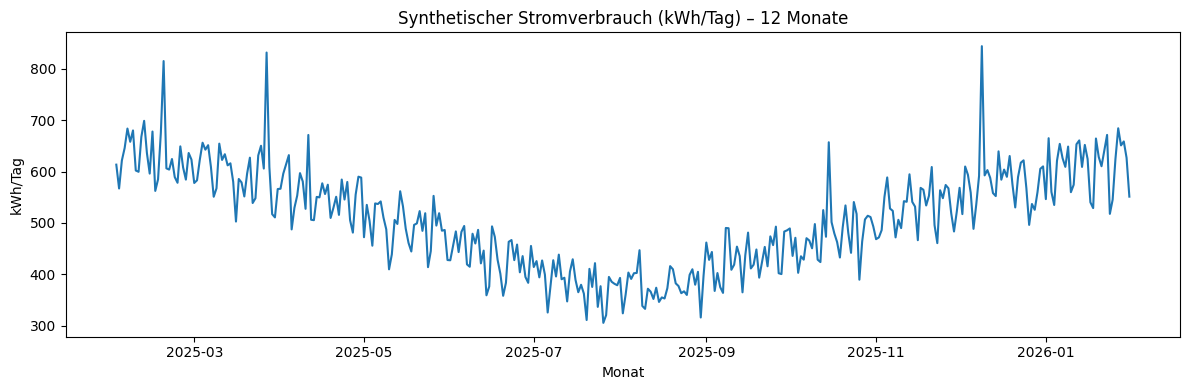

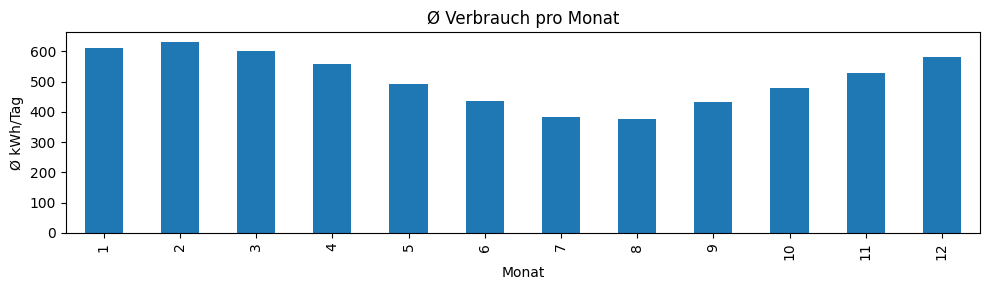

In [126]:
plt.figure(figsize=(12,4))
plt.plot(df["date"], df["y_kwh"])
plt.title("Synthetischer Stromverbrauch (kWh/Tag) – 12 Monate")
plt.xlabel("Monat")
plt.ylabel("kWh/Tag")
plt.tight_layout()
plt.show()

df.groupby(df["date"].dt.month)["y_kwh"].mean().plot(kind="bar", figsize=(10,3))
plt.title("Ø Verbrauch pro Monat")
plt.xlabel("Monat")
plt.ylabel("Ø kWh/Tag")
plt.tight_layout()
plt.show()


## 2) Feature Engineering

Genutzt werden einfache, robuste Features:
- Kalender: Monat, Wochentag, Wochenende, Feiertag, Sommerferien
- Zeit: dayofyear (optional, eher für Baumverfahren)
- Exogen: Temperatur (synthetisch)

**Wichtig:** Für Zeitreihen keine zufällige Permutation – verwendet wird TimeSeriesSplit.


In [127]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["dow"] = out["date"].dt.dayofweek
    out["is_weekend"] = (out["dow"] >= 5).astype(int)
    out["month"] = out["date"].dt.month
    out["dayofyear"] = out["date"].dt.dayofyear
    out["weekofyear"] = out["date"].dt.isocalendar().week.astype(int)
    return out

df_feat = add_time_features(df)

target_col = "y_kwh"
feature_cols = ["temp_c", "dow", "is_weekend", "month", "dayofyear", "weekofyear", "is_holiday", "is_summer_break"]

X = df_feat[feature_cols]
y = df_feat[target_col].astype(float)

X.head(), y.head()


(     temp_c  dow  is_weekend  month  dayofyear  weekofyear  is_holiday  \
 0  5.916530    5           1      2         32           5           0   
 1  3.100310    6           1      2         33           5           0   
 2  6.556381    0           0      2         34           6           0   
 3       NaN    1           0      2         35           6           0   
 4  0.910011    2           0      2         36           6           0   
 
    is_summer_break  
 0                0  
 1                0  
 2                0  
 3                0  
 4                0  ,
 0    613.5
 1    567.1
 2    621.7
 3    645.9
 4    683.8
 Name: y_kwh, dtype: float64)

## 3) Pipeline: Preprocessing + Modell

Bauen einer sklearn-Pipeline:
- Numerische Features: Imputation (Median)
- Kategorische Features: OneHotEncoding (für dow, month optional)

Tranieren eines robustes Baseline-Modells:
- `HistGradientBoostingRegressor` (schnell, starke Performance, wenig Tuning nötig)
> Trainiert werden viele kleine Entscheidungsbäume.
> Jeder neue Baum versucht, die Fehler des vorherigen zu korrigieren.
> Durch diese schrittweise Verbesserung entsteht ein sehr starkes Modell.
> Die „Histogram“-Variante ist eine schnelle Implementierung davon.

Optional: LightGBM als Vergleich.


In [128]:
num_features = ["temp_c", "dayofyear", "weekofyear"]
cat_features = ["dow", "is_weekend", "month", "is_holiday", "is_summer_break"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

hgb_model = HistGradientBoostingRegressor(
    random_state=42,
    max_depth=6,
    learning_rate=0.07,
    max_iter=400
)

hgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", hgb_model)
])

hgb_pipeline


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

Evaluieren mit:

- **MAE (Mean Absolute Error):**
$\mathrm{MAE}=\frac{1}{n}\sum_{i=1}^{n}|y_i-\hat{y}_i|$

- **RMSE (Root Mean Squared Error):**
$\mathrm{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}$


In [129]:
def eval_time_series(model: Pipeline, X: pd.DataFrame, y: pd.Series, n_splits: int = 5) -> pd.DataFrame:
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rows = []
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, pred)
        mse = mean_squared_error(y_test, pred)
        rmse = np.sqrt(mse)
        rows.append({"fold": fold, "mae": mae, "rmse": rmse, "n_test": len(test_idx)})

    return pd.DataFrame(rows)

hgb_scores = eval_time_series(hgb_pipeline, X, y, n_splits=5)
hgb_scores, hgb_scores[["mae","rmse"]].mean()


(   fold        mae       rmse  n_test
 0     1  55.178091  63.636364      60
 1     2  65.012859  73.844414      60
 2     3  38.943831  48.337408      60
 3     4  62.311733  75.414050      60
 4     5  39.953355  57.242235      60,
 mae     52.279973
 rmse    63.694894
 dtype: float64)

### Optional: LightGBM Vergleich (falls installiert)

In [130]:
if LIGHTGBM_AVAILABLE:
    lgb_model = lgb.LGBMRegressor(
        random_state=42,
        n_estimators=800,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9,
        verbosity=-1,
    )


    
    lgb_pipeline = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", lgb_model)
    ])
    
    lgb_scores = eval_time_series(lgb_pipeline, X, y, n_splits=5)
    display(lgb_scores)
    print("Mean:", lgb_scores[["mae","rmse"]].mean().to_dict())
else:
    print("LightGBM nicht verfügbar – überspringe Vergleich.")


,fold,mae,rmse,n_test
0,1,60.642738,69.939952,60
1,2,64.904062,73.782329,60
2,3,38.921785,48.815274,60
3,4,61.811614,74.629332,60
4,5,39.081090,56.461520,60


Mean: {'mae': 53.07225771059687, 'rmse': 64.72568133474098}


## 5) Finales Training + Prognose

Trainiert wird das Modell auf **allen verfügbaren Daten** und eine **Prognose für die nächsten 30 Tage** wird erstellt.
(Zur Demonstration – für echte Forecasting-Setups wären weitere Schritte wie Backtesting, Feature-Leakage-Checks, etc. sinnvoll.)


In [131]:
# Final fit
hgb_pipeline.fit(X, y)

# Forecast-Horizont
horizon_days = 30
future_dates = pd.date_range(df_feat["date"].max() + pd.Timedelta(days=1), periods=horizon_days, freq="D")

future = pd.DataFrame({"date": future_dates})
# synthetische Temperatur für die Zukunft (nur für Demo)
# -> wir extrapolieren grob per Jahres-Sinus + Rauschen
doy = future["date"].dt.dayofyear.to_numpy()
future["temp_c"] = 12 + 10 * np.sin(2 * np.pi * (doy - 172) / 365.25) + RNG.normal(0, 2.0, size=len(future))
future["is_holiday"] = future["date"].apply(lambda d: int((d.month, d.day) in {(1,1),(5,1),(8,15),(10,26),(12,25),(12,26)}))
future["is_summer_break"] = future["date"].dt.month.isin([7,8]).astype(int)

future = add_time_features(future)

X_future = future[feature_cols]
future["y_pred_kwh"] = hgb_pipeline.predict(X_future).round(1)

future.head()


,date,temp_c,is_holiday,is_summer_break,dow,is_weekend,month,dayofyear,weekofyear,y_pred_kwh
0,2026-02-01,5.916530,0,0,6,1,2,32,5,582.4
1,2026-02-02,3.100310,0,0,0,0,2,33,6,647.0
2,2026-02-03,6.556381,0,0,1,0,2,34,6,662.5
3,2026-02-04,6.813864,0,0,2,0,2,35,6,644.5
4,2026-02-05,0.910011,0,0,3,0,2,36,6,701.3


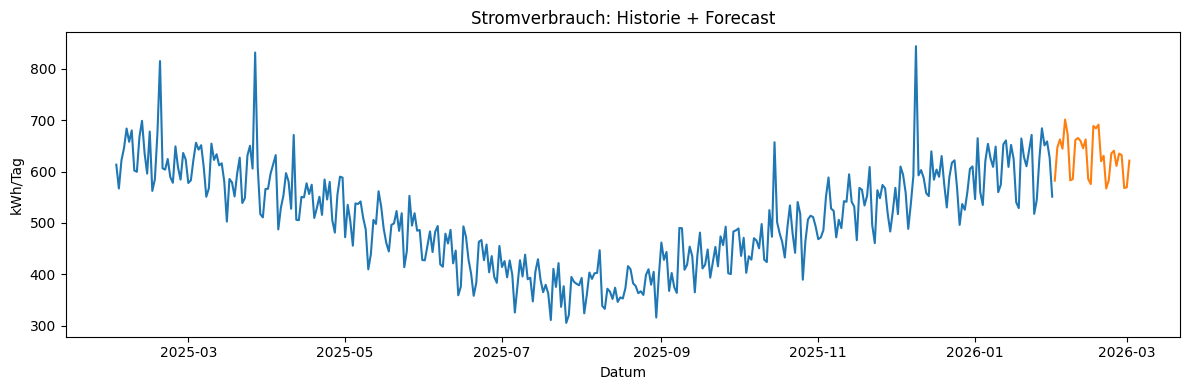

In [132]:
plt.figure(figsize=(12,4))
plt.plot(df_feat["date"], df_feat["y_kwh"], label="historisch")
plt.plot(future["date"], future["y_pred_kwh"], label="Forecast (30 Tage)")
plt.title("Stromverbrauch: Historie + Forecast")
plt.xlabel("Datum")
plt.ylabel("kWh/Tag")
plt.tight_layout()
plt.show()


## 6) Export: Daten & Forecast

Exportieren von:
- den synthetischen Trainingsdaten (CSV)
- dem Forecast (CSV)

In [133]:
from pathlib import Path

export_dir = Path("../exports")
export_dir.mkdir(exist_ok=True)

train_csv = export_dir / "synthetic_power_12_months.csv"
forecast_csv = export_dir / "forecast_next_30_days.csv"

df_feat.to_csv(train_csv, index=False)
future.to_csv(forecast_csv, index=False)

train_csv, forecast_csv


(WindowsPath('../exports/synthetic_power_12_months.csv'),
 WindowsPath('../exports/forecast_next_30_days.csv'))


MODEL PERFORMANCE (CV)



,fold,mae,rmse,n_test
0,1,55.178091,63.636364,60
1,2,65.012859,73.844414,60
2,3,38.943831,48.337408,60
3,4,62.311733,75.414050,60
4,5,39.953355,57.242235,60


Mean MAE : 52.28 kWh
Mean RMSE: 63.69 kWh

FORECAST (next 30 days)



,date,temp_c,is_holiday,is_summer_break,dow,is_weekend,month,dayofyear,weekofyear,y_pred_kwh
0,2026-02-01,5.916530,0,0,6,1,2,32,5,582.4
1,2026-02-02,3.100310,0,0,0,0,2,33,6,647.0
2,2026-02-03,6.556381,0,0,1,0,2,34,6,662.5
3,2026-02-04,6.813864,0,0,2,0,2,35,6,644.5
4,2026-02-05,0.910011,0,0,3,0,2,36,6,701.3
5,2026-02-06,2.089196,0,0,4,0,2,37,6,672.9
6,2026-02-07,4.832872,0,0,5,1,2,38,6,583.0
7,2026-02-08,3.830538,0,0,6,1,2,39,6,585.3
8,2026-02-09,4.317484,0,0,0,0,2,40,7,661.5
9,2026-02-10,2.535324,0,0,1,0,2,41,7,665.4


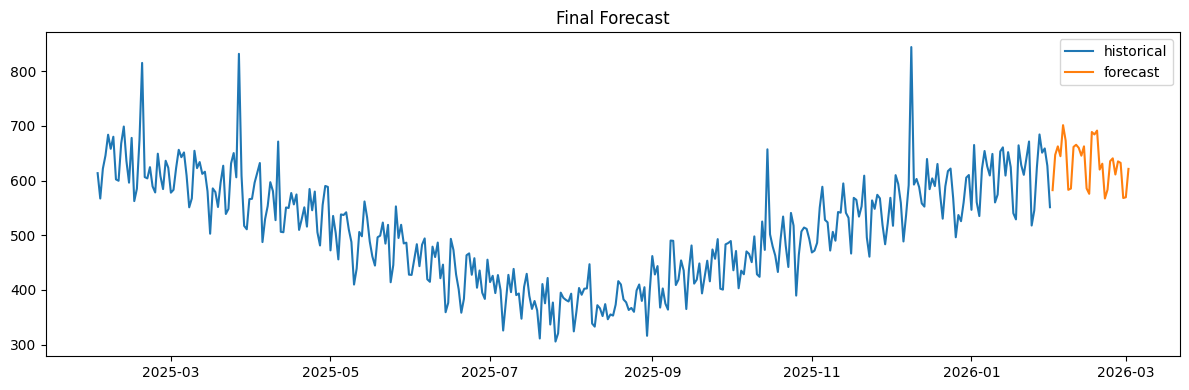


MODEL SUMMARY
{'model': 'HistGradientBoosting', 'mae': 52.27997347616556, 'rmse': 63.69489429442844, 'n_train_days': 365, 'forecast_horizon': 30}

Saved:
 - ../exports/synthetic_power_12_months.csv
 - ../exports/forecast_next_30_days.csv
 - ../exports/model_summary.json


In [134]:
# ============================================================
# FINAL OUTPUT BLOCK (für Git / Review)
# ============================================================

print("\n==============================")
print("MODEL PERFORMANCE (CV)")
print("==============================\n")

display(hgb_scores)

mean_mae = hgb_scores["mae"].mean()
mean_rmse = hgb_scores["rmse"].mean()

print(f"Mean MAE : {mean_mae:,.2f} kWh")
print(f"Mean RMSE: {mean_rmse:,.2f} kWh")


# ------------------------------------------------------------
# Forecast Output
# ------------------------------------------------------------
print("\n==============================")
print("FORECAST (next 30 days)")
print("==============================\n")

display(future.head(10))

plt.figure(figsize=(12,4))
plt.plot(df_feat["date"], df_feat["y_kwh"], label="historical")
plt.plot(future["date"], future["y_pred_kwh"], label="forecast")
plt.legend()
plt.title("Final Forecast")
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# Zusammenfassung als Dict (für Logging / JSON Export)
# ------------------------------------------------------------
summary = {
    "model": "HistGradientBoosting",
    "mae": float(mean_mae),
    "rmse": float(mean_rmse),
    "n_train_days": int(len(df_feat)),
    "forecast_horizon": int(len(future)),
}

print("\nMODEL SUMMARY")
print(summary)


# ------------------------------------------------------------
# JSON Export (einfach & funktioniert sicher)
# ------------------------------------------------------------
import json
from pathlib import Path

EXPORT_DIR = Path("../exports")
EXPORT_DIR.mkdir(exist_ok=True)

with open(EXPORT_DIR / "model_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved:")
print(" - ../exports/synthetic_power_12_months.csv")
print(" - ../exports/forecast_next_30_days.csv")
print(" - ../exports/model_summary.json")


## 7) Optional: Reale CSV laden (falls vorhanden)

Wenn echte Daten verwenden werden, kann hier eine entsprechende Datei geladen werden.
Beispiel: `Stromverbrauch_01-2026.csv` (Pfad in dieser Umgebung: `/mnt/data/Stromverbrauch_01-2026.csv`)

> **Wichtig:** ggf. Separator, Dezimalzeichen und Spaltennamen anpassen.


In [135]:
# OPTIONAL: reale CSV laden
# real_path = r"/mnt/data/Stromverbrauch_01-2026.csv"
# df_real = pd.read_csv(real_path, sep=";", decimal=",", thousands=".", encoding="utf-8", skiprows=1)
# df_real.head()
